In [18]:
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image

from utils import scale_proportional
from segmentations import binary, otsu, watershed
import description

In [2]:
# !curl -o dataset.zip "https://database.cric.com.br/api/v1/imagens/export?collection=1&images=1&classifications=0&segmentations=0"
# !mkdir -p dataset
# !unzip -q dataset.zip -d dataset

In [3]:
df = pd.read_csv('./classifications.csv')
dir_path = './dataset'
test_img = '0a2a5a681410054941cc56f51eb8fbda.png'
df[df['image_filename'] == test_img]

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
5635,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5636,Negative for intraepithelial lesion,1012,875
5636,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5637,Negative for intraepithelial lesion,910,900
5637,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5638,Negative for intraepithelial lesion,1177,416
5638,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5639,Negative for intraepithelial lesion,1254,366
5639,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5640,LSIL,983,450


In [4]:
def crop_image_around_point(image, x, y, crop_size):
    # Calculate the top-left corner of the crop
    x_start = max(0, x - int(crop_size / 2))
    y_start = max(0, y - int(crop_size / 2))

    # Calculate the bottom-right corner of the crop
    x_end = min(image.shape[1], x + int(crop_size / 2))
    y_end = min(image.shape[0], y + int(crop_size / 2))

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    return cropped_image

In [5]:
def crop_with_pil(image, x, y, crop_size):
    lcrop = int(crop_size/2)
    rcrop = int(crop_size - lcrop)
    width, height = image.size

    # Calculate the top-left corner of the crop
    x_start = max(0, x - lcrop)
    y_start = max(0, y - lcrop)

    # Calculate the bottom-right corner of the crop
    x_end = min(width, x + rcrop)
    y_end = min(height, y + rcrop)

    # Crop the image
    cropped_image = image.crop((x_start, y_start, x_end, y_end))

    return cropped_image

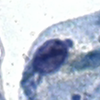

In [6]:
img_path = os.path.join(dir_path, test_img)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_img = crop_image_around_point(image, 1012, 875, 100)
Image.fromarray(cropped_img)

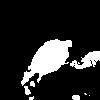

In [7]:
binary = binary(cropped_img, 127, invert=True)
Image.fromarray(binary)

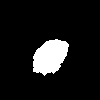

In [8]:
watershed_img = watershed(cropped_img)
Image.fromarray(watershed_img)

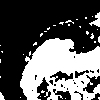

In [12]:
Image.fromarray(otsu(cropped_img, invert=True))

In [23]:
description.calculate_compactness(watershed_img)

1.3365537276220156

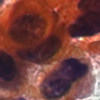

In [52]:
crop_size = 100
out_dir = './cropped_dataset/'

for index, row in df.iterrows():
    x = row.nucleus_x
    y = row.nucleus_y
    id = row.cell_id
    label = row.bethesda_system
    img_path = os.path.join(dir_path, row.image_filename)
    cropped_img_path = os.path.join(out_dir, label, str(id)+'.jpg')

    image = Image.open(img_path)
    cropped_img = crop_with_pil(image, x, y, crop_size)
    # cropped_img.save(cropped_img_path)
    break
cropped_img

In [22]:
# Example usage:
# Load your image (replace 'your_image_path.jpg' with your actual image file path)
original_image = cv2.imread(img_path)

if original_image is None:
    print("erro")
else:
    # Replace these values with the actual x, y coordinates and the desired crop size
    center_x = 1254
    center_y = 366
    crop_size = 100

    # Crop the image around the specified x, y coordinates
    cropped_image = crop_image_around_point(original_image, center_x,  center_y, crop_size)

    # Display the original and cropped images
    cv2.imwrite('./tests/ouput.png', cropped_image)
